# Hedging in the Black-Scholes Model (The Greeks)

Recall the _Black-Scholes Option Pricing Formulas_: \
In the Black-Scholes model, the price of call and put options struck on an asset with value $S_t$ at time $t$ with strike price $K$ is given by: 

$$f^{call}(S,t) = S_t \Phi(d_+) - Ke^{-r(T-t)}\Phi(d_-) \\
f^{put}(S,t) = Ke^{-r(T-t)}\Phi(-d_-) - S_t \Phi(-d_+)$$
where
$$d_\pm = \frac{\ln(S_t/K)+ (r \pm \frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T-t}} \, .$$

A claim $g$ written on the asset $S$ with payoff function $G(S)$ must satisfy the Black-Scholes PDE:
$$ \partial_t g(t,S) + r S \partial_S g(t,S) + \frac{1}{2}\sigma^2S^2 \partial_{SS}g(t,S) = r g(t,S)$$
with boundary condition $g(T,S) = G(S)$.

The B-S option pricing formulas solve the B-S PDE for calls and puts.

Script with formulas for pricing and Greeks in the B-S model:

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from scipy.stats import norm
import pdb

class BS():
    
    def CallPrice(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        
        return S*norm.cdf(dp) - K*np.exp(-r*T)*norm.cdf(dm)
    
    def PutPrice(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return K*np.exp(-r*T)*norm.cdf(-dm) - S*norm.cdf(-dp)
    
    
    def CallDelta(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return norm.cdf(dp)
    
    def PutDelta(S, T, K, sigma, r):
        
        return BS.CallDelta(S, T, K, sigma, r)-1
    
    def CallGamma(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return norm.pdf(dp)/(S*sigma*np.sqrt(T))
    
    def PutGamma(S, T, K, sigma, r):
        
        return BS.CallGamma(S, T, K, sigma, r)
    
    def CallVega(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return norm.pdf(dp)*S*np.sqrt(T)
    
    def CallTheta(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return -S*norm.pdf(dp)*sigma/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(dm)
    
    def PutTheta(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return -S*norm.pdf(dp)*sigma/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-dm)
    
    def CallRho(S, T, K, sigma, r):
        
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return K*T*np.exp(-r*T)*norm.pdf(dm)
    
    def PutRho(S, T, K, sigma, r):
        
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return -K*T*np.exp(-r*T)*norm.pdf(-dm)    

Script for solving the B-S PDE:

In [17]:
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default='notebook' # set = 'browser' when not in Jupyter notebook

import pdb

#from BS import BS

class BS_PDE():
    
    def __init__(self, T, F, f_exact, S0 = 10, sigma=0.2, r = 0.01, NdT = 1_000):
        
        self.NdT = NdT
        self.T = T
        self.t = np.linspace(0,self.T, self.NdT+1)
        self.dt = self.t[1] - self.t[0]
        
        self.S0 = S0
        self.sigma = sigma
        self.r = r
        
        self.dx = np.sqrt(3*self.dt)*self.sigma
        eff_std = self.sigma*np.sqrt(self.T)
        n_std = 3
        self.Ndx = int(2*n_std*eff_std/self.dx) + 1
        self.x = np.linspace(-n_std*eff_std,
                             n_std*eff_std, 
                             self.Ndx)
        self.dx = self.x[1]-self.x[0]
        
        self.S = self.S0 * np.exp(self.x)
        
        self.F = F
        self.f_exact = f_exact
        
    def Solve(self):
        
        f = np.zeros((self.Ndx, self.NdT+1))
        
        
        f[:,-1] = self.F(self.S)
        
        for i in range(self.NdT-1, -1, -1):
            
            d_dx_f = (f[2:,i+1] - f[:-2,i+1])/(2*self.dx)
            d_dxdx_f = (f[2:,i+1] - 2*f[1:-1,i+1] + f[:-2,i+1])/self.dx**2
            
            f[1:-1,i] = f[1:-1,i+1] + self.dt*((self.r-0.5*self.sigma**2) * d_dx_f
                                               + 0.5*self.sigma**2 * d_dxdx_f 
                                               - self.r*f[1:-1:,i+1])
            
            f[0,i] = 2*f[1,i] - f[2,i]
            f[-1,i] = 2*f[-2,i] - f[-3,i]
            
        fig = go.Figure(data=[go.Surface(x=self.t, y=self.S, z=f)])

        fig.update_layout(title='***', #autosize=False, width=600, height=500,
                          margin=dict(l=65, r=50, b=65, t=90),
                          scene=dict(
                              xaxis=dict(title='t'),
                              yaxis=dict(title='S', range=(self.S0*0.6,self.S0*1.4)),
                              zaxis=dict(title='f(t,S)'),))
        idx = -1
        for i in range(5):
            
            # fig.add_trace(go.Scatter3d(x=self.t[idx]*np.ones(self.t.shape), y=S, z=f[:,idx],mode='lines'))
            fig.add_trace(go.Scatter3d(x=self.t[idx]*np.ones(self.t.shape), 
                                       y=self.S[::5], 
                                       z=self.f_exact(self.S[::5], self.T - self.t[idx]),
                                       showlegend=False))
            
            idx -= int(self.NdT/5)
        
        fig.show()
        
        return f
        

## PDE Example

In [18]:
#from BS_PDE import BS_PDE
#from BS import BS

S0 = 10
sigma = 0.2
r = 0.02

K = 10
T = 1

# Call
F = lambda S : np.maximum(S-K,0)
f_exact = lambda S, tau: BS.CallPrice(S, tau, K, sigma, r)

model = BS_PDE(T=T, F=F, f_exact=f_exact, S0=S0, sigma=sigma, r=r, NdT=1_000)
f = model.Solve()

# Put
F = lambda S : np.maximum(K-S,0)
f_exact = lambda S, tau: BS.PutPrice(S, tau, K, sigma, r)

model = BS_PDE(T=T, F=F, f_exact=f_exact, S0=S0, sigma=sigma, r=r, NdT=1_000)
f = model.Solve()

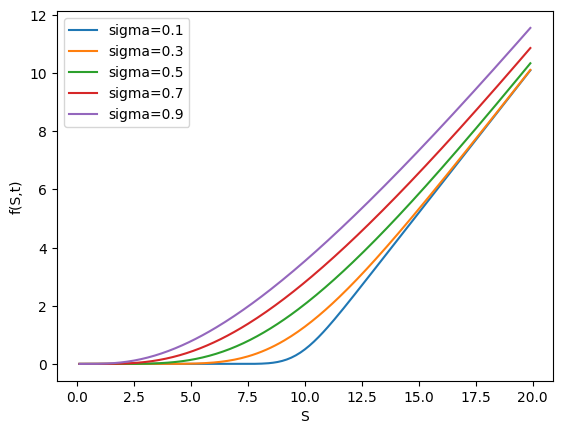

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
S = np.arange(0.1, 20, 0.1)
sigma_vec = np.linspace(0.1,0.9,5)


Callprice = np.zeros(shape=(len(sigma_vec),len(S)))

for i in range(len(sigma_vec)):
    Callprice[i,:] = BS.CallPrice(S, T, K, sigma_vec[i], r)
    ax.plot(S, Callprice[i], label = "sigma="+ str(round(sigma_vec[i],2)))

ax.set(xlabel='S', ylabel='f(S,t)')
plt.legend()
plt.show()

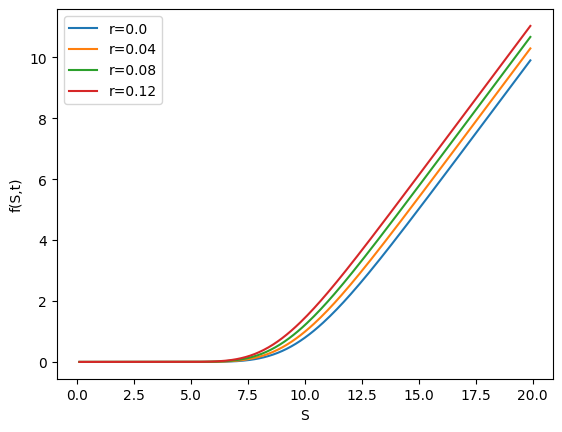

In [5]:
fig, ax = plt.subplots()
S = np.arange(0.1, 20, 0.1)
r_vec = np.linspace(0,0.12,4)


Callprice = np.zeros(shape=(len(r_vec),len(S)))

for i in range(len(r_vec)):
    Callprice[i,:] = BS.CallPrice(S, T, K, sigma, r_vec[i])
    ax.plot(S, Callprice[i], label = "r="+ str(r_vec[i]))

ax.set(xlabel='S', ylabel='f(S,t)')
plt.legend()
plt.show()

# The Greeks

## Delta 

$$\Delta = \frac{\partial f}{\partial S}$$

For European calls and puts, we have: \
$\Delta^{call} = \Phi(d_+)$ \
$\Delta^{put} = - \Phi(-d_+) = \Phi(d_+) - 1$ 

In [6]:
S0 = 10
sigma = 0.2
r = 0.02
K = 10
T = 1

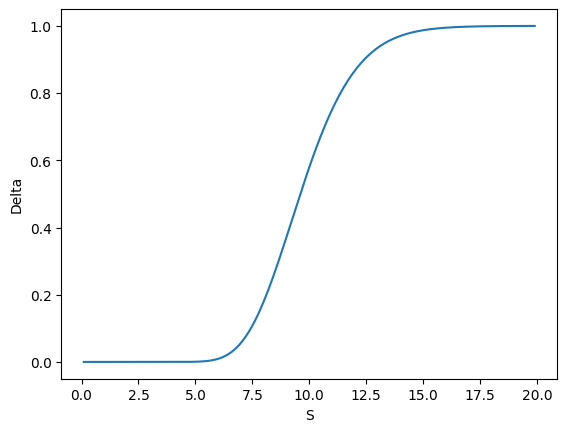

In [7]:
fig, ax = plt.subplots()
S = np.arange(0.1, 20, 0.1)

Delta_call = BS.CallDelta(S, T, K, sigma, r)
ax.plot(S, Delta_call)
ax.set(xlabel='S', ylabel='Delta')
plt.show()

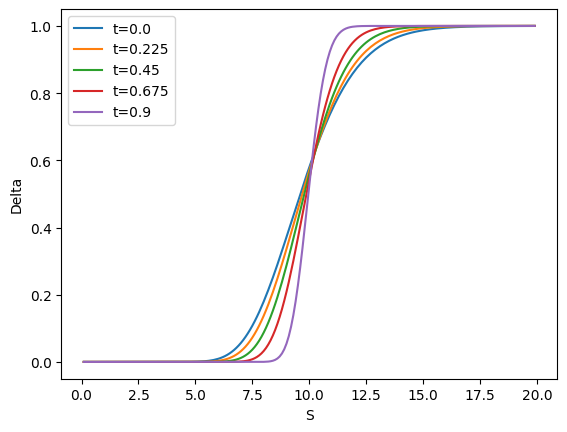

In [8]:
fig, ax = plt.subplots()
S = np.arange(0.1, 20, 0.1)
tvec = np.linspace(0,0.9,5)


Delta_call = np.zeros(shape=(len(tvec),len(S)))

for i in range(len(tvec)):
    Delta_call[i,:] = BS.CallDelta(S, T-tvec[i], K, sigma, r)
    ax.plot(S, Delta_call[i], label = "t="+ str(tvec[i]))

ax.set(xlabel='S', ylabel='Delta')
plt.legend()
plt.show()



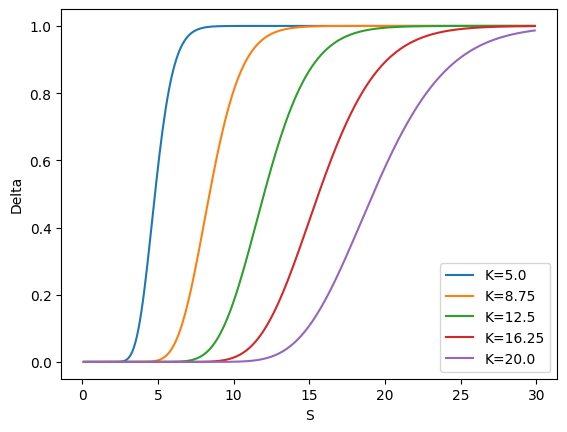

In [9]:
fig, ax = plt.subplots()
S = np.arange(0.1, 30, 0.1)
K_vec = np.linspace(5,20,5)


Delta_call = np.zeros(shape=(len(K_vec),len(S)))

for i in range(len(K_vec)):
    Delta_call[i,:] = BS.CallDelta(S, T, K_vec[i], sigma, r)
    ax.plot(S, Delta_call[i], label = "K="+ str(K_vec[i]))

ax.set(xlabel='S', ylabel='Delta')
plt.legend()
plt.show()



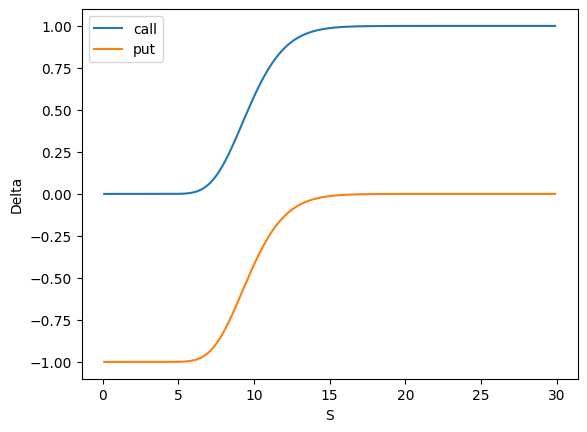

In [10]:
Delta_call = BS.CallDelta(S, T, K, sigma, r)
Delta_put = BS.PutDelta(S, T, K, sigma, r)
fig, ax = plt.subplots()
ax.plot(S, Delta_call, label = "call")
ax.plot(S, Delta_put, label = "put")
ax.set(xlabel='S', ylabel='Delta')
plt.legend()
plt.show()

## Gamma

$$\Gamma = \frac{\partial^2 f}{\partial S^2}$$

For European calls and puts, we have: 
$$\Gamma^{call} = \frac{\phi(d_+)}{S \sigma \sqrt{T-t}} = \Gamma^{put}$$

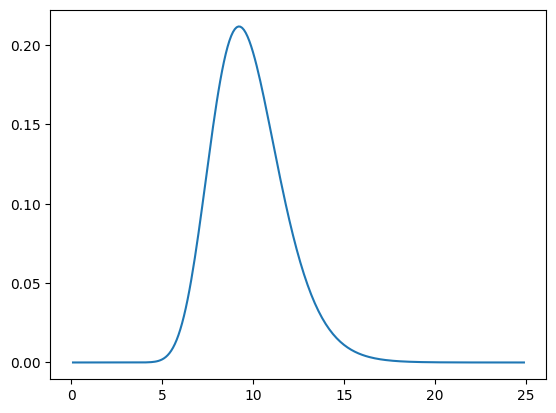

In [11]:
fig, ax = plt.subplots()
S = np.arange(0.1, 25, 0.1)
Gamma= BS.CallGamma(S, T, K, sigma, r) 
ax.plot(S, Gamma)
plt.show()

## Vega

$$\mathcal{V} = \frac{\partial f}{\partial \sigma}$$

For European calls and puts, we have: 
$$\mathcal{V}^{call}(S,t) = S \phi(d_+) \sqrt{T-t} = \mathcal{V}^{put}(S,t)$$

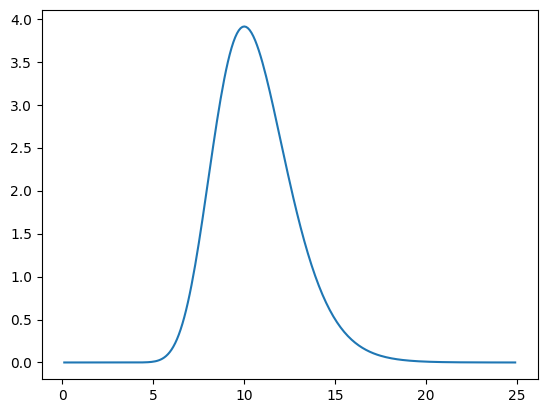

In [12]:
fig, ax = plt.subplots()
S = np.arange(0.1, 25, 0.1)
Vega_call = BS.CallVega(S, T, K, sigma, r) 
#Gamma_put = BS.PutGamma(S, T, K, sigma, r)
ax.plot(S, Vega_call, label = "call")
#ax.plot(S, Gamma_put, label = "put")

plt.show()

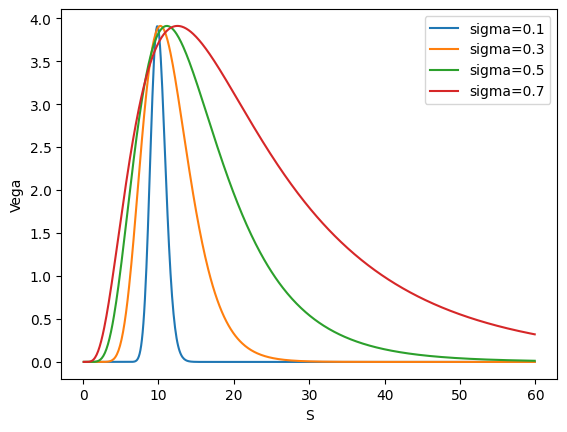

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
S = np.arange(0.1, 60, 0.1)
sigma_vec = np.linspace(0.1,0.7,4)


Vega = np.zeros(shape=(len(sigma_vec),len(S)))

for i in range(len(sigma_vec)):
    Vega[i,:] = BS.CallVega(S, T, K, sigma_vec[i], r)
    ax.plot(S, Vega[i], label = "sigma="+ str(sigma_vec[i]))

ax.set(xlabel='S', ylabel='Vega')
plt.legend()
plt.show()

## Theta

$$\Theta = \frac{\partial f}{\partial t}$$

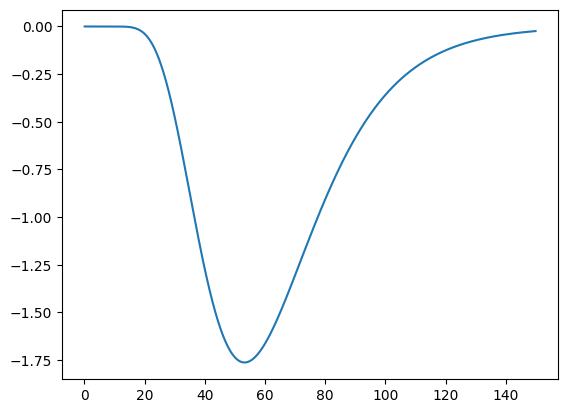

In [14]:
K=50
T=2
r=0
sigma=0.25

fig, ax = plt.subplots()
S = np.arange(0.1, 150, 0.1)
Theta_call = BS.CallTheta(S, T, K, sigma, r) 
ax.plot(S, Theta_call)
plt.show()

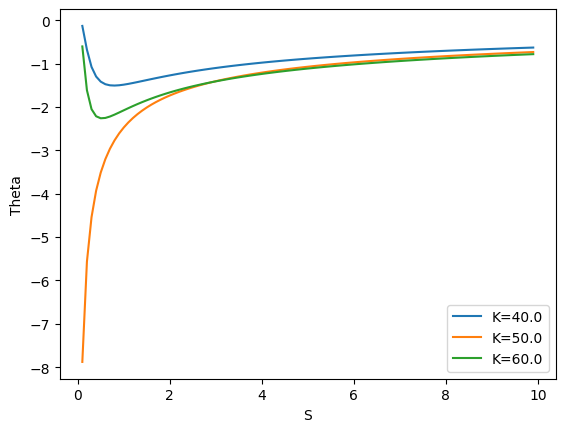

In [15]:
fig, ax = plt.subplots()
T_vec = np.arange(0, 10, 0.1)
K_vec = np.linspace(40,60,3)
S=50
r=0
sigma=0.25


Theta_call = np.zeros(shape=(len(K_vec),len(T_vec)))

for i in range(len(K_vec)):
    Theta_call[i,:] = BS.CallTheta(S, T_vec, K_vec[i], sigma, r)
    ax.plot(T_vec, Theta_call[i], label = "K="+ str(K_vec[i]))

ax.set(xlabel='S', ylabel='Theta')
plt.legend()
plt.show()



## Rho

$$\rho = \frac{\partial f}{\partial r}$$

For European calls and puts, we have: \
$$\rho^{call} = K (T-t) e^{-r(T-t)}\Phi(d_-)\\
\rho^{put} = - K (T-t) e^{-r(T-t)}\Phi(-d_-) $$

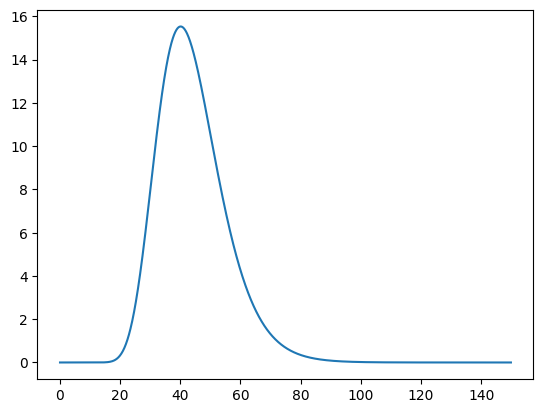

In [16]:
K=50
T=1
r=0.25
sigma=0.25

fig, ax = plt.subplots()
S = np.arange(0.1, 150, 0.1)
Rho_call = BS.CallRho(S, T, K, sigma, r) 
ax.plot(S, Rho_call)
plt.show()